In [42]:
%config InlineBackend.figure_format = 'svg'
from IPython.core.magic import register_cell_magic
from IPython.display import display, HTML

import re

class WardleyMap():
    title = None
    nodes = {}
    edges = []
    evolutions = {}
    annotations = []
    annotation = {}
    notes = []
    style = None

    warnings = []

    # Developed using https://regex101.com/
    _coords_regexs = "\[\s*([\d\.-]+)\s*,\s*([\d\.-]+)\s*\]"
    _node_regex = re.compile(r"^(\w+) ([\w ]+)\s+{COORDS}(\s+label\s+{COORDS})*".format(COORDS=_coords_regexs))
    _evolve_regex = re.compile(r"^evolve ([\w ]+)\s+([\d\.-]+)(\s+label\s+{COORDS})*".format(COORDS=_coords_regexs))

    def __init__(self, owm):
        for cl in owm.splitlines():
            cl = cl.strip()
            if not cl:
                continue
            if cl.startswith('title '):
                self.title = cl.split(' ', maxsplit=1)[1]
            elif cl.startswith('style '):
                self.style = cl.split(' ', maxsplit=1)[1]
            elif cl.startswith('anchor ') or cl.startswith('component '):
                # Use RegEx to split into fields:
                match = self._node_regex.search(cl)
                if match != None:
                    matches = match.groups()
                    node = {
                        'type' : matches[0],
                        'title': matches[1],
                        'vis' : float(matches[2]),
                        'mat' : float(matches[3])
                    }
                    # Handle label position adjustments:
                    if matches[4]:
                        node['label_x'] = float(matches[5])
                        node['label_y'] = float(matches[6])
                    else:
                        # Default to a small additional offset:
                        node['label_x'] = 2
                        node['label_y'] = 2
                    # And store it:
                    self.nodes[node['title']] = node
                else:
                    self.warnings.append("Could not parse component line: %s" % cl)
            elif "->" in cl:
                n_from, n_to = cl.split('->')
                self.edges.append([n_from.strip(), n_to.strip()])
            elif cl.startswith('evolve '):
                match = self._evolve_regex.search(cl)
                if match != None:
                    matches = match.groups()
                    evol = {
                        'title' : matches[0],
                        'mat' : float(matches[1])
                    }
                    # Handle label position adjustments:
                    if matches[2]:
                        evol['label_x'] = float(matches[3])
                        evol['label_y'] = float(matches[4])
                    else:
                        # Default to a small additional offset:
                        evol['label_x'] = 2
                        evol['label_y'] = 2
                    # And store it:
                    self.evolutions[matches[0]] = evol
                else:
                    self.warnings.append("Could not parse evolution line: %s" % cl)
            else:
                # Warn about lines we can't handle?
                self.warnings.append("Could not parse line: %s" % cl)


@register_cell_magic
def wardley(line, cell):
    "Wardley mapping"

    # Helper to report problems:
    def show_warning(message):
        display(HTML("<strong>WARNING:</strong> %s" % message))

    # Parse the OWM syntax:
    wm = WardleyMap(cell)

    # Show warnings if problems were found:
    for message in wm.warnings:
        show_warning(message)
    if len(wm.evolutions) > 0:
        show_warning("Displaying evolutions is not implemented yet!")

    # Now plot:
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection

    fig, ax = plt.subplots(figsize=(12, 8))

    if wm.title:
        plt.title(wm.title)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Plot the lines:
    l = []
    for edge in wm.edges:
        if edge[0] in wm.nodes and edge[1] in wm.nodes:
            n_from = wm.nodes[edge[0]]
            n_to = wm.nodes[edge[1]]
            l.append([ (n_from['mat'],n_from['vis']), (n_to['mat'],n_to['vis']) ])
        else:
            for n in edge:
                if n not in wm.nodes:
                    show_warning("Could not find a component called '%s'!" % n)
    if len(l) > 0:
        lc = LineCollection(l, color="k", lw=1, linestyle=['-'])
        ax.add_collection(lc)

    # Add the nodes:
    for node_title in wm.nodes:
        n = wm.nodes[node_title]
        if n['type'] == 'component':
            plt.plot(n['mat'], n['vis'], marker='o', color='w', markeredgecolor='k', markeredgewidth=1.0)
        ax.annotate(node_title, fontsize=10,
            xy=(n['mat'], n['vis']), xycoords='data',
            xytext=(n['label_x'], n['label_y']), textcoords='offset pixels',
            horizontalalignment='left', verticalalignment='bottom')

    plt.yticks([0.0,0.925], ['Invisible', 'Visible'], rotation=90, verticalalignment='bottom')
    plt.ylabel('Value Chain', fontweight='bold')
    plt.xticks([0.0, 0.25,0.5, 0.75], ['Genesis', 'Custom-Built', 'Product\n(+rental)', 'Commodity\n(+utility)'], ha='left')
    plt.xlabel('Evolution', fontweight='bold')

    plt.tick_params(axis='x', direction='in', top=True, bottom=True, grid_linewidth=1)
    plt.grid(b=True, axis='x', linestyle='--')
    plt.tick_params(axis='y', length=0)
    
    # Styles:
    if wm.style == 'wardley':
        # Add the gradient background
        norm = matplotlib.colors.Normalize(0,1)
        colors = [[norm(0.0), "white"], [norm(0.5), "white"], [norm(1.0), "whitesmoke"]]
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
        plotlim = plt.xlim() + plt.ylim()
        ax.imshow([[1,0,1],[1,0,1]], cmap=cmap, interpolation='bicubic', extent=plotlim, aspect='auto')
    elif wm.style != None:
        show_warning("Map style '%s' not recognised or supported." % wm.style)

    #plt.tight_layout()
    plt.show()
    
    return None

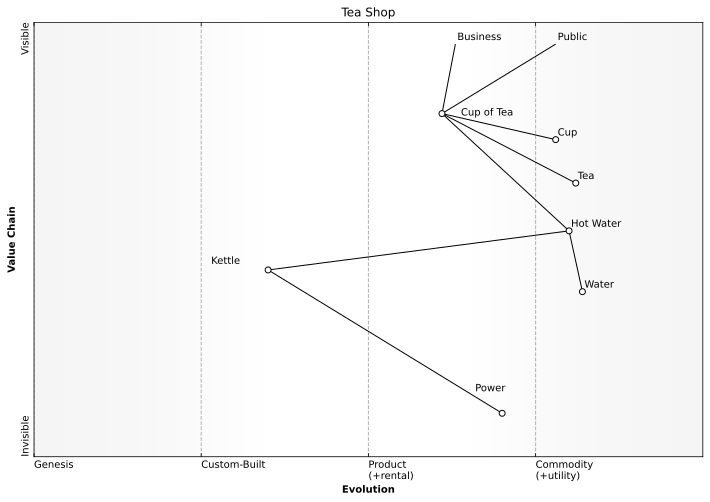

In [43]:
%%wardley
title Tea Shop
anchor Business [0.95, 0.63]
anchor Public [0.95, 0.78]
component Cup of Tea [0.79, 0.61] label [19, -4]
component Cup [0.73, 0.78]
component Tea [0.63, 0.81]
component Hot Water [0.52, 0.80]
component Water [0.38, 0.82]
component Kettle [0.43, 0.35] label [-57, 4]
evolve Kettle 0.62 label [16, 7]
component Power [0.1, 0.7] label [-27, 20]
evolve Power 0.89 label [-12, 21]
Business->Cup of Tea
Public->Cup of Tea
Cup of Tea->Cup
Cup of Tea->Tea
Cup of Tea->Hot Water
Hot Water->Water
Hot Water->Kettle 
Kettle->Power

annotation 1 [[0.43,0.49],[0.08,0.79]] Standardising power allows Kettles to evolve faster
annotation 2 [0.48, 0.85] Hot water is obvious and well known
annotations [0.60, 0.02]

note +a generic note appeared [0.23, 0.33]

style wardley